# GloFAS reanalysis / Floodscan
<!-- markdownlint-disable MD013 -->
Validation of GloFAS reanalysis using Floodscan in relevant LGAs or pixels

In [2]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from src.datasources import glofas, codab
from src.constants import *
from src.utils import blob

## Load data

In [4]:
station_name = "wuroboki"

In [5]:
df_ra = glofas.load_glofas_reanalysis(station_name=station_name)

In [6]:
df_ra

,time,dis24
0,1979-01-01,79.656250
1,1979-01-02,77.609375
2,1979-01-03,76.515625
3,1979-01-04,75.671875
4,1979-01-05,74.843750
...,...,...
16736,2024-10-27,1411.625000
16737,2024-10-28,1280.859375
16738,2024-10-29,1156.441406
16739,2024-10-30,1043.812500


In [7]:
adm2 = codab.load_codab_from_blob(admin_level=2, aoi_only=True)

In [8]:
pcodes = BENUE_ADM2_PCODES

In [9]:
query = f"""
SELECT *
FROM public.floodscan
WHERE pcode IN {tuple(pcodes)}
"""

In [10]:
df_fs = pd.read_sql(
    query, stratus.get_engine(stage="prod"), parse_dates=["valid_date"]
)

In [11]:
df_sfed = df_fs[df_fs["band"] == "SFED"]

In [12]:
blob_name = f"{blob.PROJECT_PREFIX}/processed/floodscan/fs_benue_pixels_1998_2024.parquet"
df_fs_pixels = stratus.load_parquet_from_blob(blob_name)

In [13]:
df_fs_pixels["pixel_id"] = (
    df_fs_pixels["x"].astype(str) + "_" + df_fs_pixels["y"].astype(str)
)

In [14]:
df_fs_pixels

,y,x,date,SFED,pixel_id
18970,9.5417,11.6250,1998-01-12,0.0,11.625_9.5417
18971,9.5417,11.6250,1998-01-13,0.0,11.625_9.5417
18972,9.5417,11.6250,1998-01-14,0.0,11.625_9.5417
18973,9.5417,11.6250,1998-01-15,0.0,11.625_9.5417
18974,9.5417,11.6250,1998-01-16,0.0,11.625_9.5417
...,...,...,...,...,...
34748,9.2917,12.7917,2024-12-31,0.0,12.7917_9.2917
34749,9.2917,12.8750,2024-12-31,0.0,12.875_9.2917
34763,9.2083,12.4583,2024-12-31,0.0,12.4583_9.2083
34764,9.2083,12.5417,2024-12-31,0.0,12.5417_9.2083


## Compare pixels

See which pixels have the best correlation with GloFAS reanalysis

In [15]:
df_compare_pixels = df_ra.rename(columns={"time": "date"}).merge(df_fs_pixels)

In [16]:
dicts = []
for (x, y), group in df_compare_pixels.groupby(["x", "y"]):
    dicts.append(
        {
            "x": x,
            "y": y,
            "corr": group.corr(numeric_only=True).loc["dis24", "SFED"],
        }
    )

In [17]:
df_compare_pixels.groupby("date")[["SFED", "dis24"]].mean().corr()

,SFED,dis24
SFED,1.000000,0.656897
dis24,0.656897,1.000000


In [18]:
df_corr_pixels = pd.DataFrame(dicts).sort_values("corr", ascending=False)

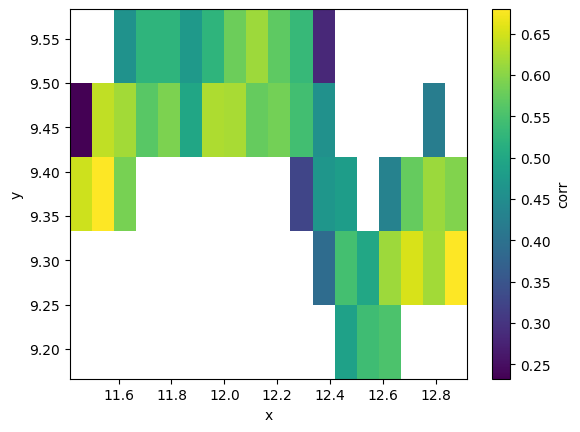

In [19]:
df_corr_pixels.set_index(["y", "x"]).to_xarray()["corr"].plot()

In [20]:
df_corr_pixels.sort_values("corr", ascending=False)

,x,y,corr
41,12.8750,9.2917,0.679578
2,11.5417,9.3750,0.678709
36,12.7083,9.2917,0.653091
0,11.4583,9.3750,0.645211
3,11.5417,9.4583,0.637335
13,11.9583,9.4583,0.624586
15,12.0417,9.4583,0.620254
5,11.6250,9.4583,0.618002
38,12.7917,9.2917,0.617757
34,12.6250,9.2917,0.614134


In [21]:
top_x, top_y = df_corr_pixels.sort_values("corr", ascending=False).iloc[1][
    ["x", "y"]
]

## Combine reanalysis with Floodscan

There are a few different ways we can select with Floodscan pixels to use in the comparison. 

Run only the relevant cells to merge that Floodscan aggregation for comparison.

### 1. Use admin2 Floodscan raster stats

In [22]:
df_compare = (
    df_ra.rename(columns={"time": "valid_date"})
    .merge(df_sfed.rename(columns={"pcode": "ADM2_PCODE"}))
    .merge(adm2[["ADM2_PCODE", "ADM2_EN"]])
)

In [23]:
for name, group in df_compare.groupby("ADM2_EN"):
    print(name)
    display(group.corr(numeric_only=True).loc["dis24", "mean"])

Demsa


0.5896512223904927

Fufore


0.5900184664007332

Girei


0.5205615424260316

Lamurde


0.5792614020327401

Numan


0.6248268112247629

Yola North


0.5504210929460868

Yola South


0.4675068392951233

In [24]:
df_compare_adm2 = df_compare[df_compare["ADM2_PCODE"] == NUMAN2].copy()

### 2. Use mean of pixels

In [25]:
df_compare_adm2 = (
    df_compare_pixels.groupby("date")[["dis24", "SFED"]]
    .mean()
    .reset_index()
    .copy()
    .rename(columns={"date": "valid_date", "SFED": "mean"})
)

### 3. Use the best pixel

In [26]:
df_compare_adm2 = (
    df_compare_pixels[
        (df_compare_pixels["x"] == top_x) & (df_compare_pixels["y"] == top_y)
    ]
    .copy()
    .rename(columns={"date": "valid_date", "SFED": "mean"})
)

## Further processing

In [27]:
df_compare_adm2["mean"] = (
    df_compare_adm2["mean"].rolling(7, center=True).mean()
)

In [29]:
df_compare_adm2["year"] = df_compare_adm2["valid_date"].dt.year

df_compare_adm2 = df_compare_adm2[df_compare_adm2["year"] >= 2003]

<Axes: xlabel='valid_date'>

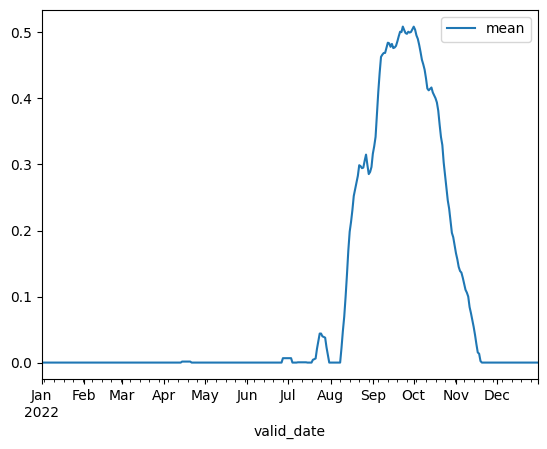

In [30]:
df_plot = df_compare_adm2[df_compare_adm2["valid_date"].dt.year == 2022].copy()
df_plot.plot(x="valid_date", y="mean")

In [31]:
df_plot.loc[df_plot["mean"].idxmax()]

valid_date    2022-09-23 00:00:00
dis24                  4099.90625
y                           9.375
x                         11.5417
mean                     0.508804
pixel_id            11.5417_9.375
year                         2022
Name: 387884, dtype: object

In [32]:
df_compare_adm2[df_compare_adm2["valid_date"].dt.year == 2022]

,valid_date,dis24,y,x,mean,pixel_id,year
376489,2022-01-01,67.937500,9.375,11.5417,0.0,11.5417_9.375,2022
376532,2022-01-02,65.953125,9.375,11.5417,0.0,11.5417_9.375,2022
376575,2022-01-03,64.843750,9.375,11.5417,0.0,11.5417_9.375,2022
376618,2022-01-04,64.281250,9.375,11.5417,0.0,11.5417_9.375,2022
376661,2022-01-05,64.156250,9.375,11.5417,0.0,11.5417_9.375,2022
...,...,...,...,...,...,...,...
391969,2022-12-27,74.976562,9.375,11.5417,0.0,11.5417_9.375,2022
392012,2022-12-28,75.210938,9.375,11.5417,0.0,11.5417_9.375,2022
392055,2022-12-29,75.210938,9.375,11.5417,0.0,11.5417_9.375,2022
392098,2022-12-30,75.125000,9.375,11.5417,0.0,11.5417_9.375,2022


### Calculate peaks

In [33]:
# For dis24
dis24_max_idx = df_compare_adm2.groupby("year")["dis24"].idxmax()
dis24_max_df = df_compare_adm2.loc[
    dis24_max_idx, ["year", "valid_date", "dis24"]
].rename(columns={"valid_date": "rea_date", "dis24": "rea_max"})

# For mean
mean_max_idx = df_compare_adm2.groupby("year")["mean"].idxmax()
mean_max_df = df_compare_adm2.loc[
    mean_max_idx, ["year", "valid_date", "mean"]
].rename(columns={"valid_date": "fs_date", "mean": "fs_max"})

# Merge the two results
df_peaks = pd.merge(dis24_max_df, mean_max_df, on="year", how="outer")

In [34]:
for x in ["rea", "fs"]:
    df_peaks[f"{x}_date_doy"] = pd.to_datetime(
        df_peaks[f"{x}_date"].dt.dayofyear, format="%j"
    )
df_peaks

,year,rea_date,rea_max,fs_date,fs_max,rea_date_doy,fs_date_doy
0,2003,2003-09-19,3312.015625,2003-09-23,0.362853,1900-09-19,1900-09-23
1,2004,2004-09-07,1856.578125,2004-09-01,0.150186,1900-09-08,1900-09-02
2,2005,2005-08-15,2077.328125,2005-08-26,0.239967,1900-08-15,1900-08-26
3,2006,2006-09-23,1733.757812,2006-09-23,0.249691,1900-09-23,1900-09-23
4,2007,2007-09-22,2235.781250,2007-09-18,0.257654,1900-09-22,1900-09-18
5,2008,2008-08-27,2627.976562,2008-09-20,0.171076,1900-08-28,1900-09-21
6,2009,2009-09-05,2169.906250,2009-09-09,0.234019,1900-09-05,1900-09-09
7,2010,2010-09-07,3109.257812,2010-09-17,0.198867,1900-09-07,1900-09-17
8,2011,2011-09-14,2461.625000,2011-09-18,0.160464,1900-09-14,1900-09-18
9,2012,2012-08-21,3110.078125,2012-09-20,0.575426,1900-08-22,1900-09-21


## Plotting

### Peak accuracy

In [48]:
rea_color = "royalblue"
fs_color = "crimson"
both_color = "purple"
none_color = "grey"

Text(0, 0.5, 'Floodscan yearly peak')

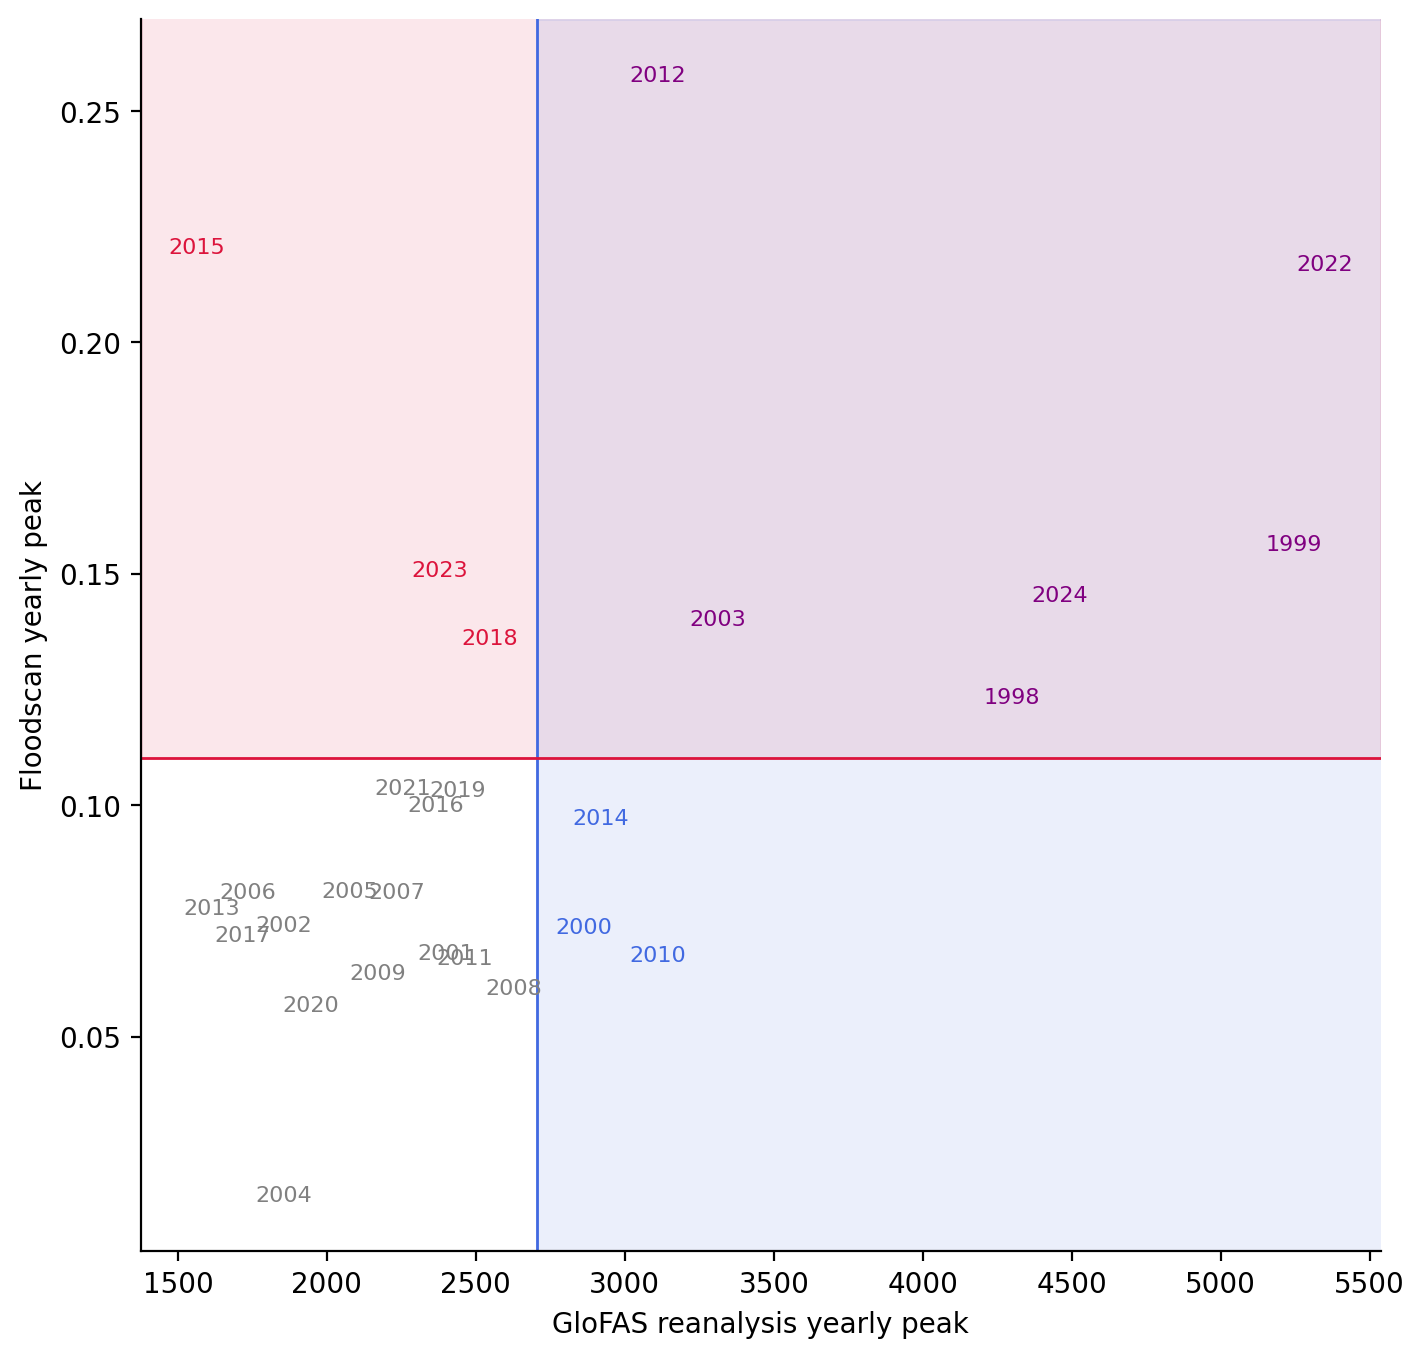

In [49]:
fig, ax = plt.subplots(dpi=200, figsize=(8, 8))

xmin, ymin = df_peaks[["rea_max", "fs_max"]].min()
xmax, ymax = df_peaks[["rea_max", "fs_max"]].max()
xrange = xmax - xmin
yrange = ymax - ymin
pad = 0.05
xlims = (xmin - xrange * pad, xmax + xrange * pad)
ylims = (ymin - yrange * pad, ymax + yrange * pad)

rp = 3

rea_thresh = df_peaks["rea_max"].quantile(1 - 1 / rp)
fs_thresh = df_peaks["fs_max"].quantile(1 - 1 / rp)

ax.axvline(rea_thresh, color=rea_color, linewidth=1)
ax.axhline(fs_thresh, color=fs_color, linewidth=1)

ax.axhspan(fs_thresh, 2, color=fs_color, alpha=0.1)
ax.axvspan(rea_thresh, 10000, color=rea_color, alpha=0.1)

for year, row in df_peaks.set_index("year").iterrows():
    if (row["rea_max"] >= rea_thresh) & (row["fs_max"] >= fs_thresh):
        color = both_color
    elif row["rea_max"] >= rea_thresh:
        color = rea_color
    elif row["fs_max"] >= fs_thresh:
        color = fs_color
    else:
        color = none_color
    ax.annotate(
        year,
        (row["rea_max"], row["fs_max"]),
        ha="center",
        va="center",
        fontsize=8,
        color=color,
    )

ax.set_xlim(xlims)
ax.set_ylim(ylims)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("GloFAS reanalysis yearly peak")
ax.set_ylabel("Floodscan yearly peak")

### Peak timing

/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_25972/2432479288.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("BrBG")


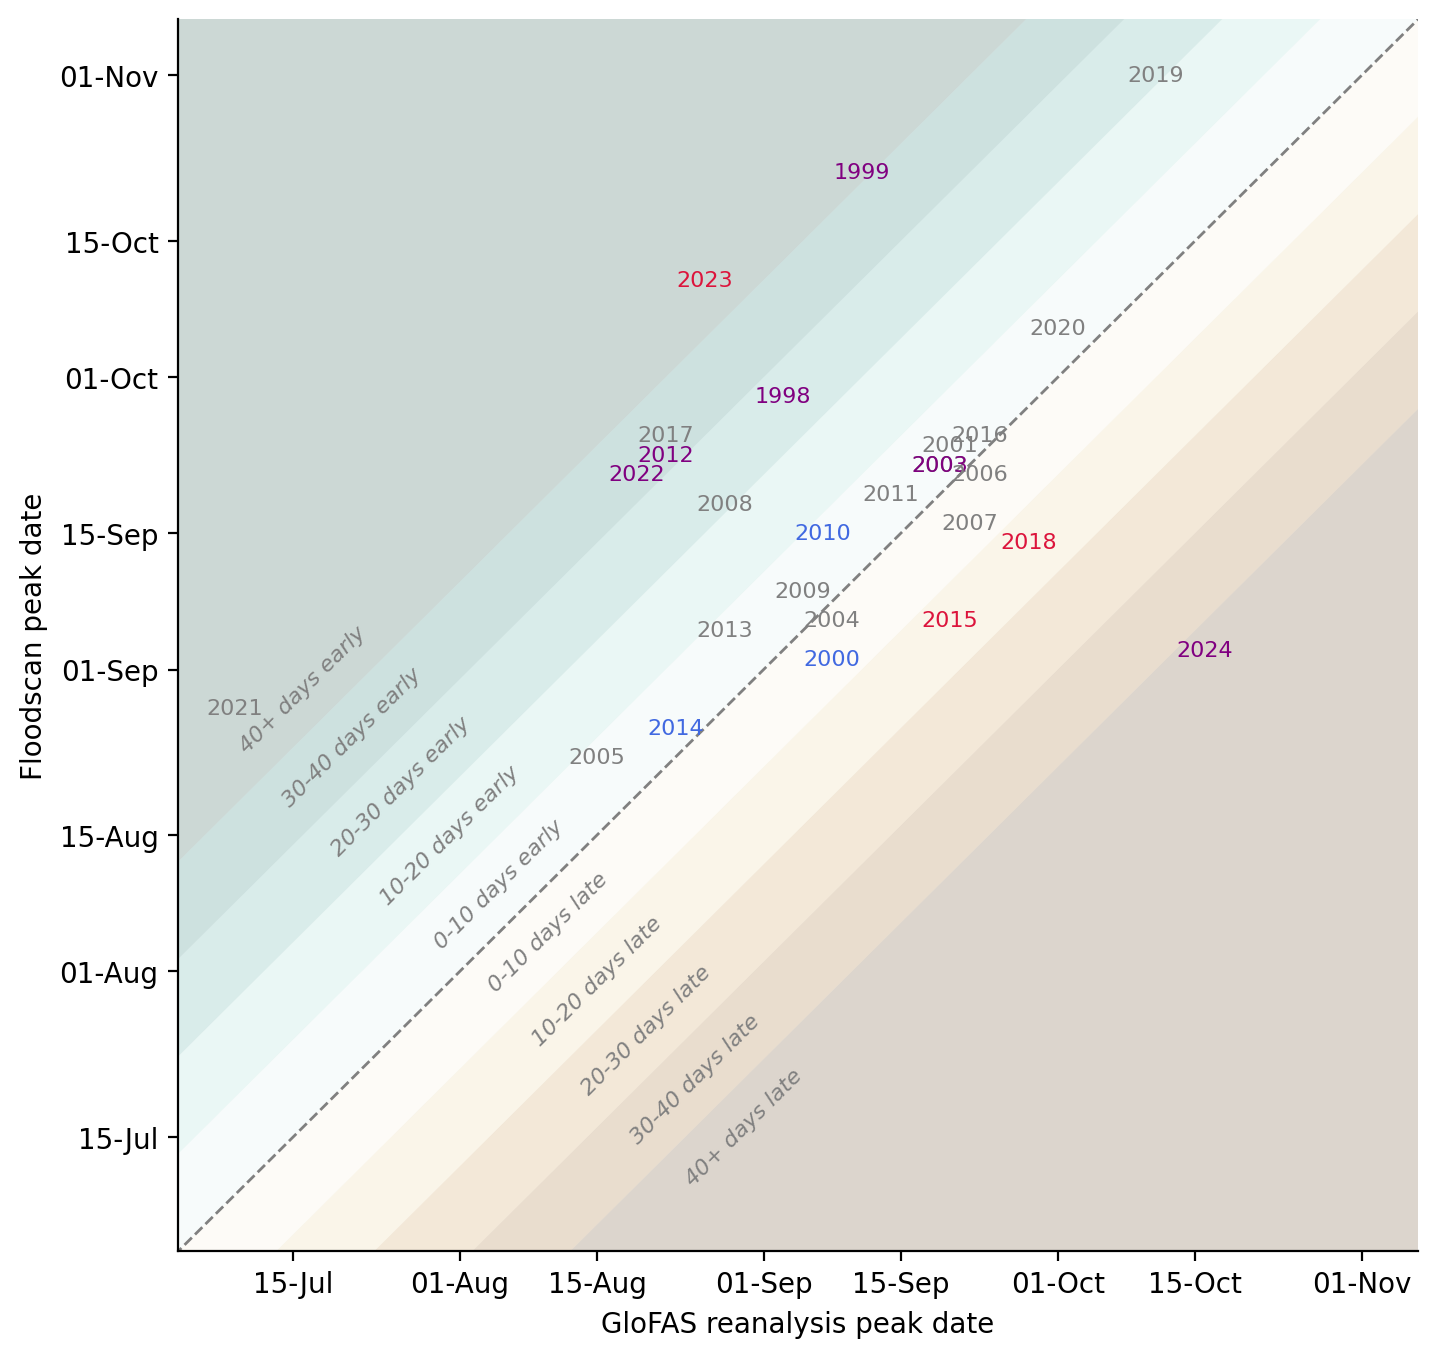

In [51]:
fig, ax = plt.subplots(dpi=200, figsize=(8, 8))

rp = 3

xmin = df_peaks[["rea_date_doy", "fs_date_doy"]].min().min()
xmax = df_peaks[["rea_date_doy", "fs_date_doy"]].max().max()
xrange = xmax - xmin
pad = 0.05
lims = (xmin - xrange * pad, xmax + xrange * pad)

rea_thresh = df_peaks["rea_max"].quantile(1 - 1 / rp)
fs_thresh = df_peaks["fs_max"].quantile(1 - 1 / rp)

dates_45 = pd.to_datetime(["1900-01-01", "1900-12-31"])

ax.plot(
    dates_45,
    dates_45,
    linewidth=1,
    color="grey",
    linestyle="--",
)

alpha = 0.2

days_early_list = range(-50, 41, 10)
norm = mcolors.Normalize(vmin=min(days_early_list), vmax=max(days_early_list))
cmap = cm.get_cmap("BrBG")

for days_early in days_early_list:
    if days_early == max(days_early_list):
        upper_dates = 0
    else:
        upper_dates = dates_45 + pd.DateOffset(days=days_early + 10)
    if days_early == min(days_early_list):
        lower_dates = dates_45 + pd.DateOffset(days=-1000)
    else:
        lower_dates = dates_45 + pd.DateOffset(days=days_early)
    ax.fill_between(
        dates_45,
        lower_dates,
        upper_dates,
        facecolor=cmap(norm(days_early)),
        alpha=alpha,
    )
    if days_early < 0:
        annotation = (
            f"{-days_early-10}+ days late"
            if days_early == min(days_early_list)
            else f"{-days_early-10}-{-days_early} days late"
        )
    else:
        annotation = (
            f"{days_early}+ days early"
            if days_early == max(days_early_list)
            else f"{days_early}-{days_early+10} days early"
        )
    ax.annotate(
        annotation,
        (
            pd.to_datetime("1900-08-10")
            - pd.DateOffset(days=days_early / 2 + 5),
            pd.to_datetime("1900-08-10") + pd.DateOffset(days=days_early / 2),
        ),
        rotation=45,
        ha="center",
        va="center",
        fontsize=8,
        fontstyle="italic",
        color="grey",
    )

for year, row in df_peaks.set_index("year").iterrows():
    if (row["rea_max"] >= rea_thresh) & (row["fs_max"] >= fs_thresh):
        color = both_color
    elif row["rea_max"] >= rea_thresh:
        color = rea_color
    elif row["fs_max"] >= fs_thresh:
        color = fs_color
    else:
        color = none_color
    ax.annotate(
        year,
        (row["rea_date_doy"], row["fs_date_doy"]),
        ha="center",
        va="center",
        fontsize=8,
        color=color,
    )

ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel("GloFAS reanalysis peak date")
ax.set_ylabel("Floodscan peak date")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
ax.yaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [39]:
df_peaks

,year,rea_date,rea_max,fs_date,fs_max,rea_date_doy,fs_date_doy
0,1998,1998-09-03,4300.250000,1998-09-27,0.133422,1900-09-03,1900-09-27
1,1999,1999-09-11,5244.656250,1999-10-21,0.177807,1900-09-11,1900-10-21
2,2000,2000-09-07,2863.234375,2000-09-01,0.085177,1900-09-08,1900-09-02
3,2001,2001-09-20,2399.468750,2001-09-24,0.049942,1900-09-20,1900-09-24
4,2002,2002-09-19,1854.218750,2002-09-22,0.087929,1900-09-19,1900-09-22
5,2003,2003-09-19,3312.015625,2003-09-21,0.134886,1900-09-19,1900-09-21
6,2004,2004-09-07,1856.578125,2004-09-11,0.025681,1900-09-08,1900-09-12
7,2005,2005-08-15,2077.328125,2005-08-23,0.060904,1900-08-15,1900-08-23
8,2006,2006-09-23,1733.757812,2006-09-19,0.099854,1900-09-23,1900-09-19
9,2007,2007-09-22,2235.781250,2007-09-15,0.093251,1900-09-22,1900-09-15


### Timeseries

/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_62661/1387165645.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots()


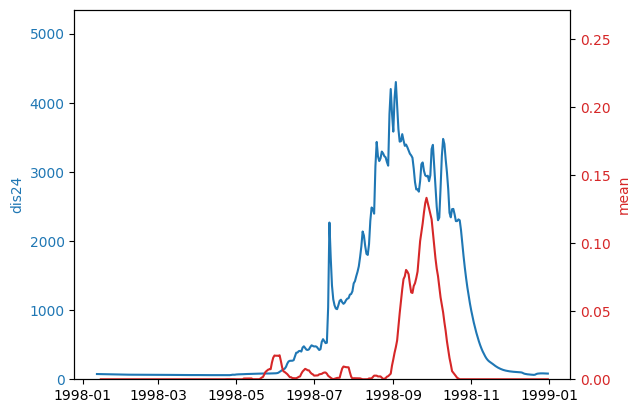

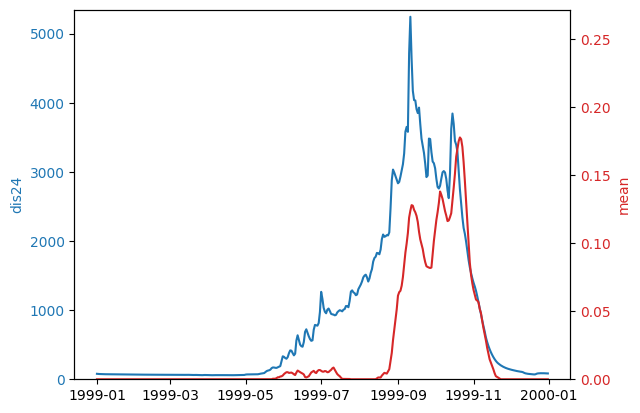

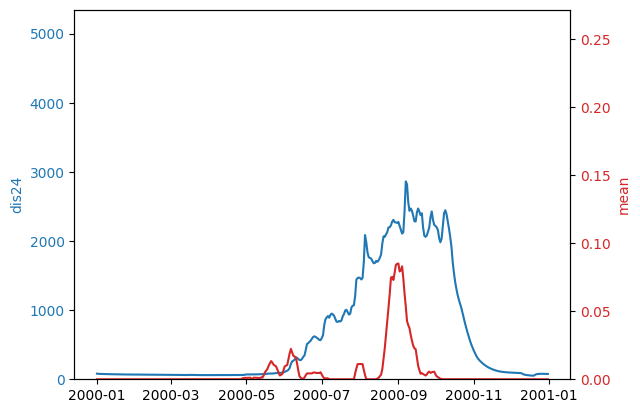

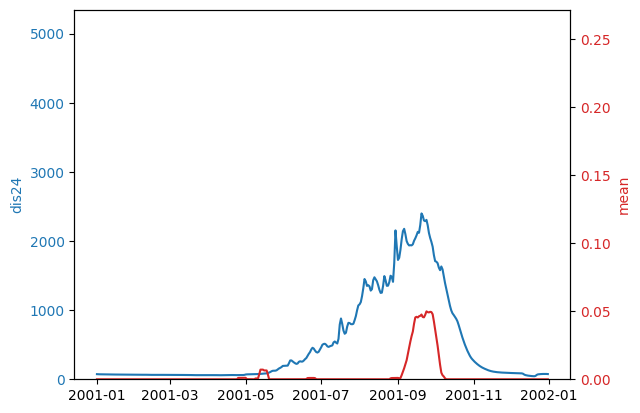

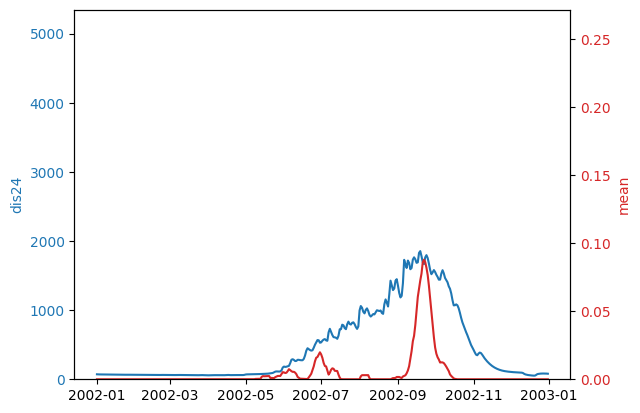

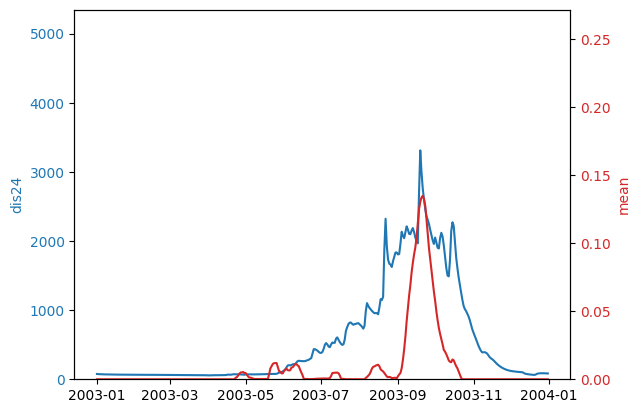

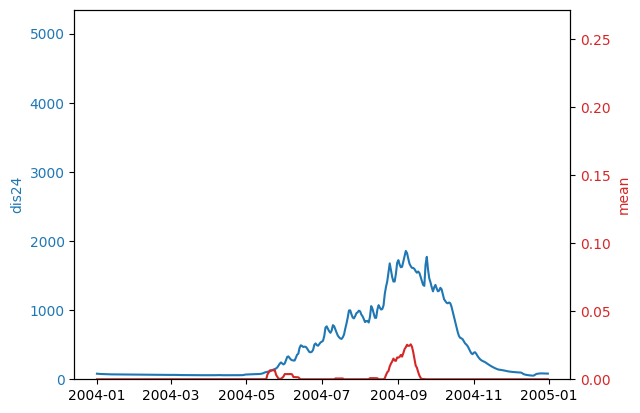

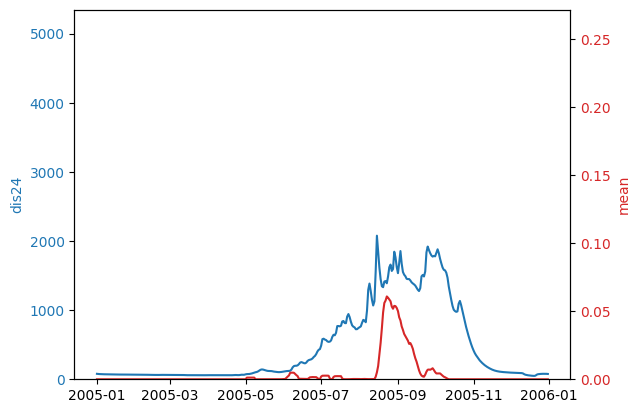

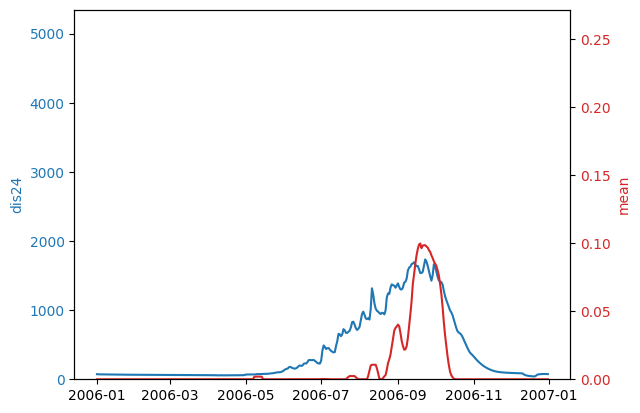

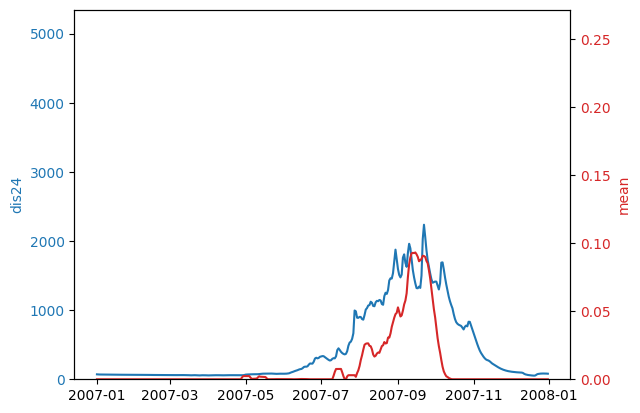

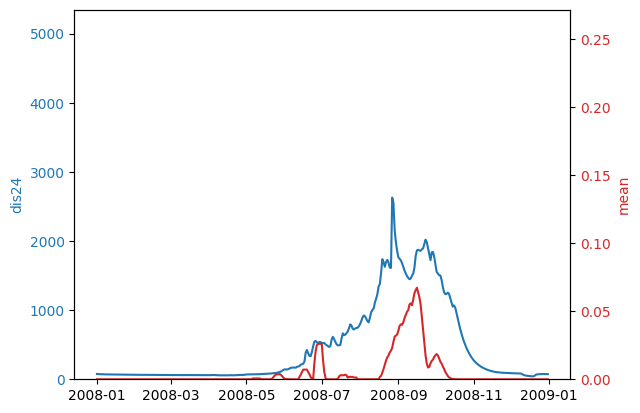

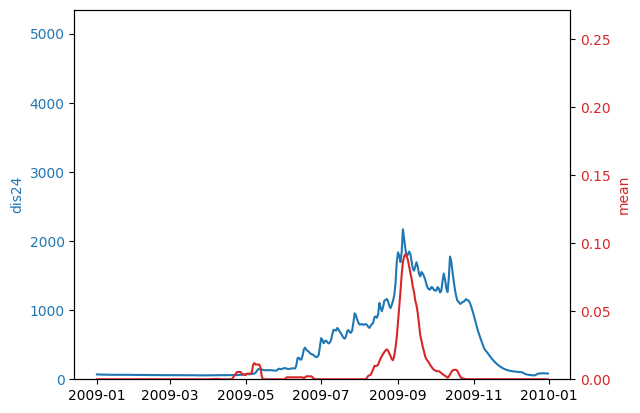

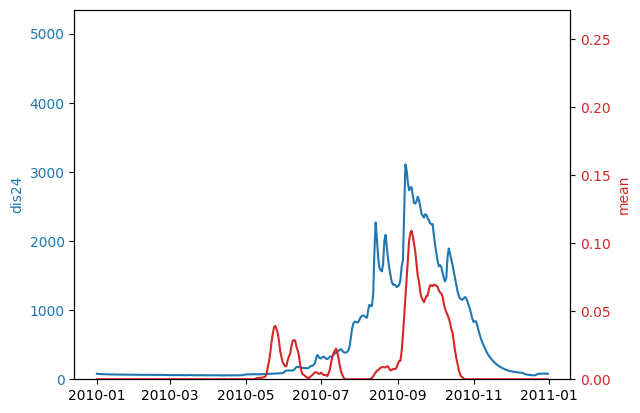

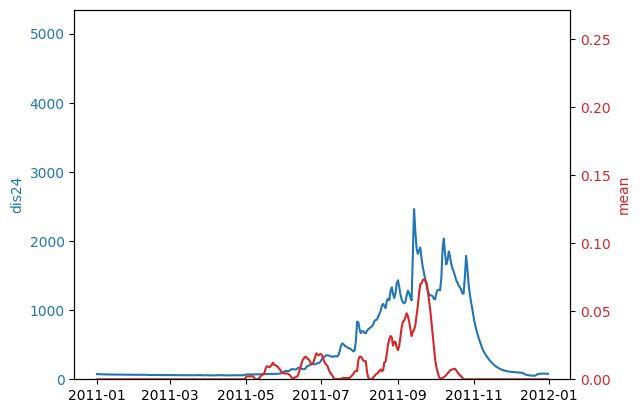

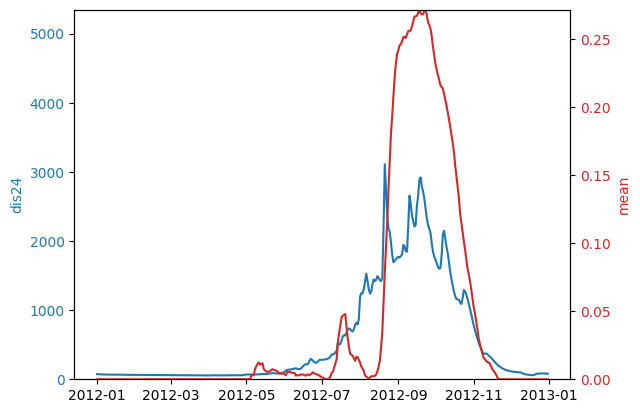

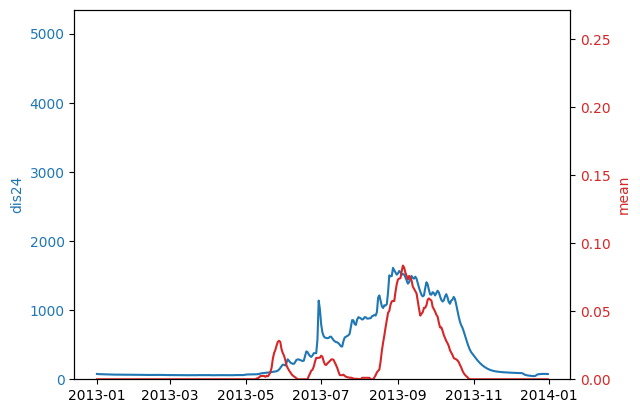

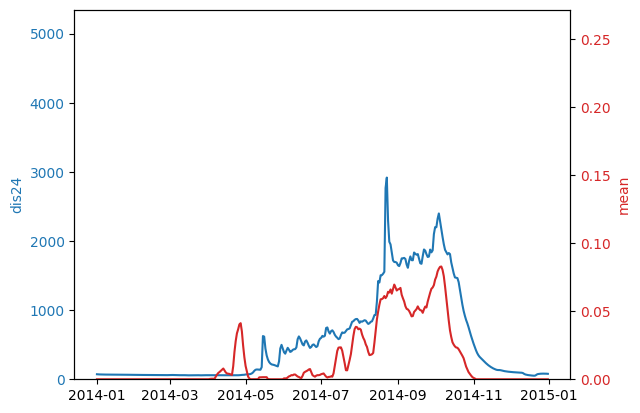

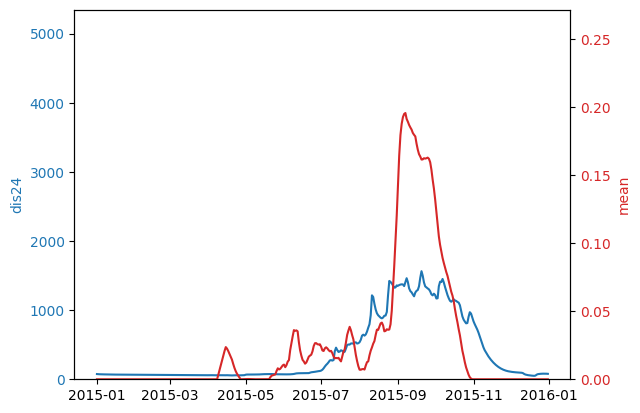

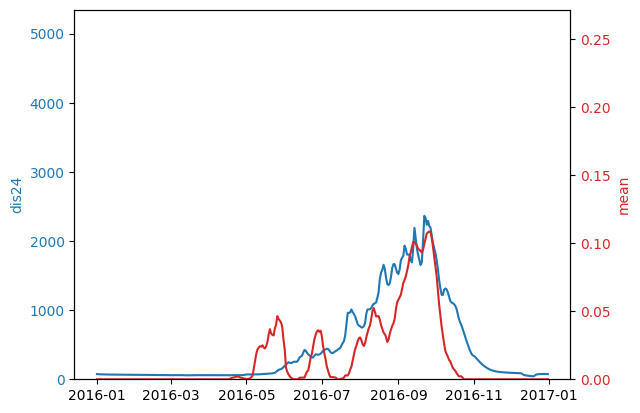

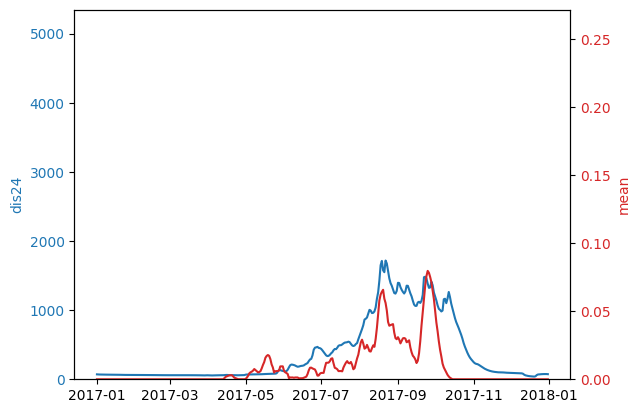

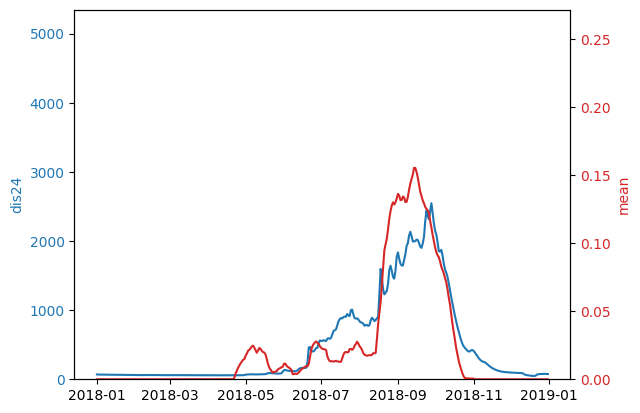

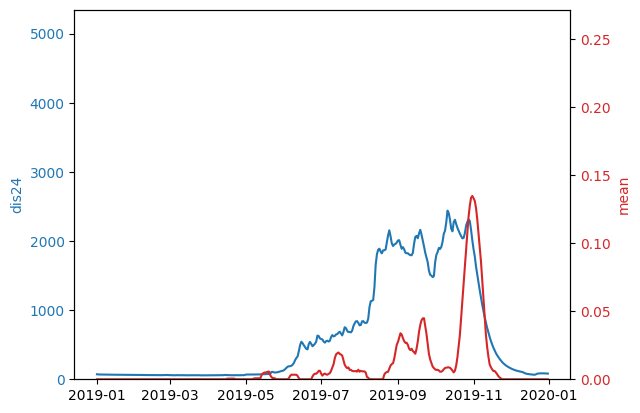

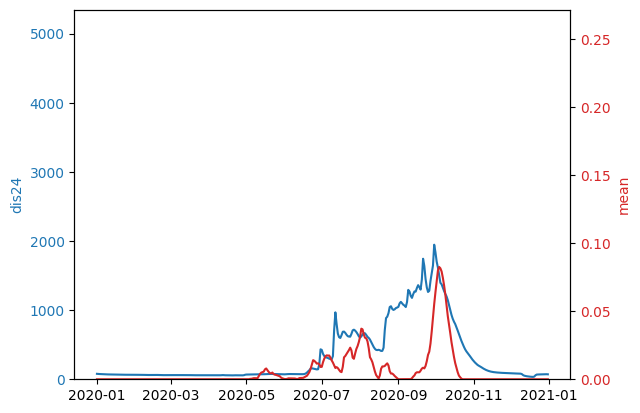

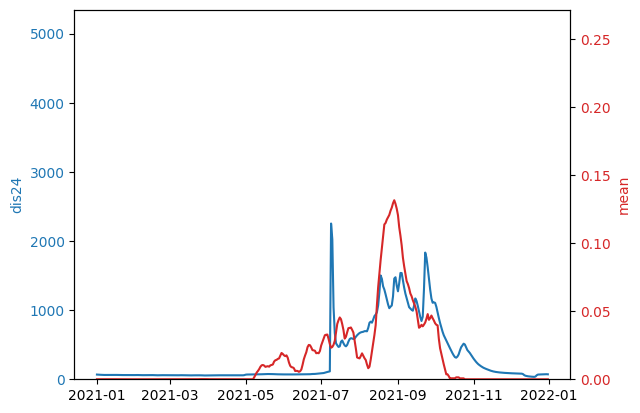

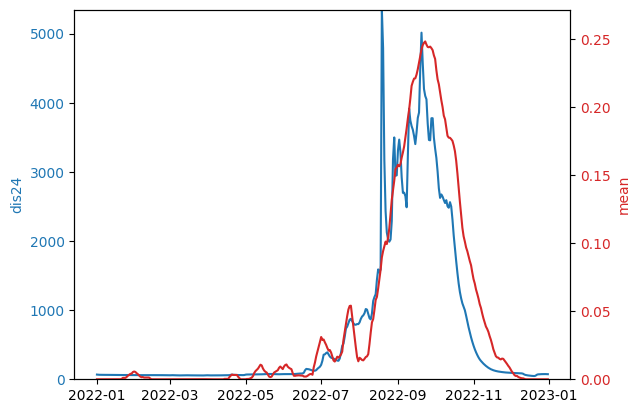

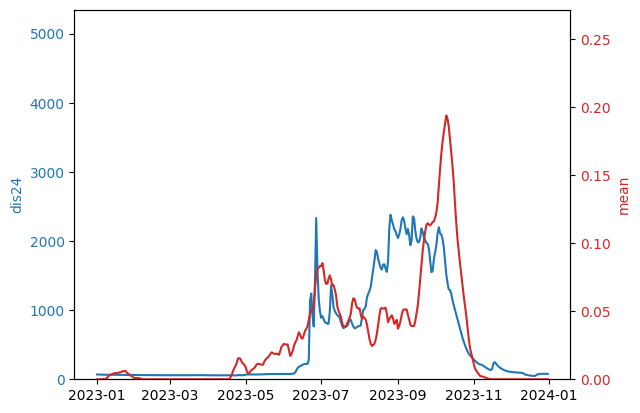

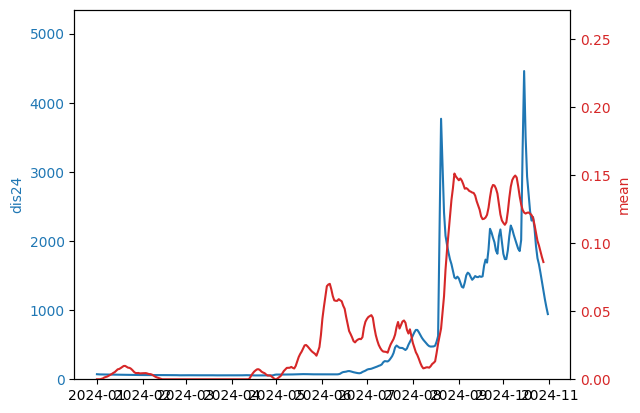

In [504]:
dis_max, fs_max = df_compare_adm2[["dis24", "mean"]].max()

for year, group in df_compare_adm2.groupby("year"):
    fig, ax1 = plt.subplots()

    # Plot dis24 on the primary y-axis
    ax1.plot(
        group["valid_date"], group["dis24"], color="tab:blue", label="dis24"
    )
    ax1.set_ylabel("dis24", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.set_ylim(bottom=0, top=dis_max)

    # Create a second y-axis
    ax2 = ax1.twinx()
    ax2.plot(group["valid_date"], group["mean"], color="tab:red", label="mean")
    ax2.set_ylabel("mean", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")
    ax2.set_ylim(bottom=0, top=fs_max)